In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_SingleStep_v8 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-20 10:41:01.802775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 10:41:01.803283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 10:41:01.867544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 10:41:01.867895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 10:41:01.868279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

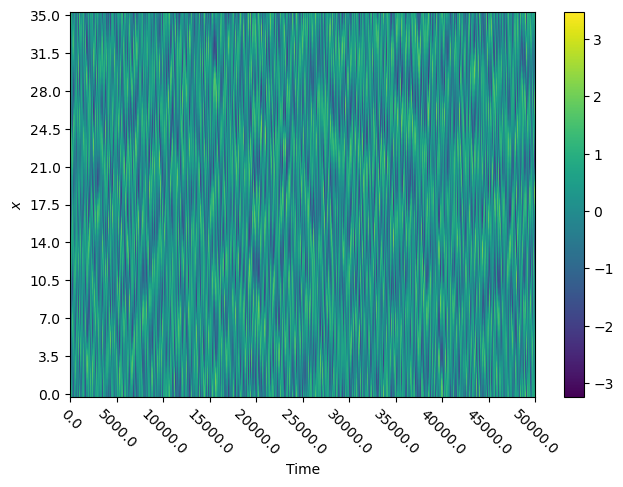

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

if ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]

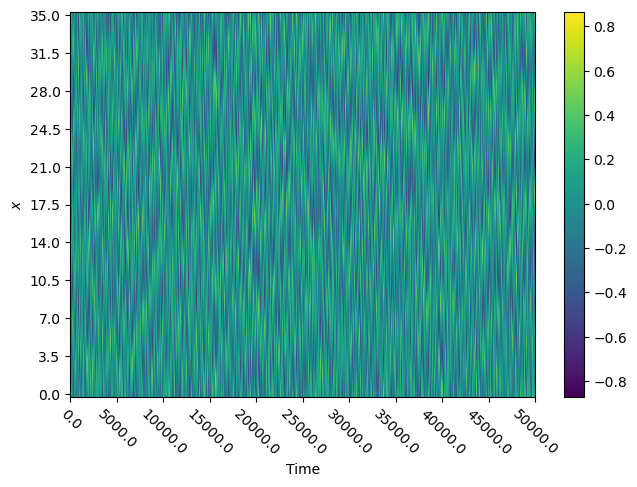

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [19]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

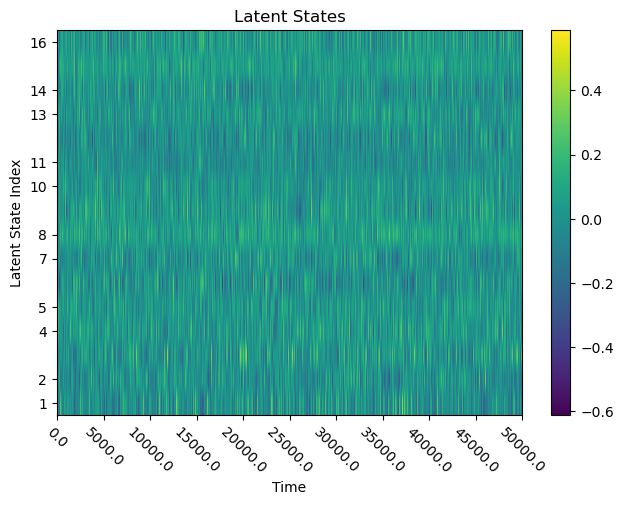

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 1/2
    noise_type = 'uniform' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    dense_layer_act_func = ['linear']
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [38]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

NameError: name 'org_data_idx_arr_input' is not defined

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.5/100

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

del(idx)

In [39]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (1029, 387, 16)
 testing_data_rnn_input.shape :  (1029, 387, 16)
     val_data_rnn_input.shape :  (1029, 387, 16)


In [29]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**8]*2
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.17670502
stddev : 0.000883525088429451


In [30]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [31]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse'],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
17/17 [==============================] - ETA: 0s - loss: 0.0326 - mse: 0.0317 - tot_time: 0h 2m 57.0s

Epoch 1: val_loss improved from inf to 0.00792, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 177s 2s/step - loss: 0.0326 - mse: 0.0317 - val_loss: 0.0079 - val_mse: 0.0070
Epoch 2/1000
17/17 [==============================] - ETA: 0s - loss: 0.0061 - mse: 0.0052 - tot_time: 0h 3m 4.5s

Epoch 2: val_loss improved from 0.00792 to 0.00449, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/chec

17/17 [==============================] - ETA: 0s - loss: 9.0847e-04 - mse: 1.7049e-04 - tot_time: 0h 4m 48.8s

Epoch 16: val_loss improved from 0.00092 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 433ms/step - loss: 9.0847e-04 - mse: 1.7049e-04 - val_loss: 8.8674e-04 - val_mse: 1.5595e-04
Epoch 17/1000
17/17 [==============================] - ETA: 0s - loss: 8.7527e-04 - mse: 1.5011e-04 - tot_time: 0h 4m 56.1s

Epoch 17: val_loss improved from 0.00089 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 433ms/step - loss: 8.7527e-04 - mse

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 430ms/step - loss: 6.5756e-04 - mse: 7.1442e-05 - val_loss: 6.6919e-04 - val_mse: 8.7423e-05
Epoch 32/1000
17/17 [==============================] - ETA: 0s - loss: 6.6102e-04 - mse: 8.2662e-05 - tot_time: 0h 6m 47.3s

Epoch 32: val_loss improved from 0.00066 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 438ms/step - loss: 6.6102e-04 - mse: 8.2662e-05 - val_loss: 6.4353e-04 - val_mse: 6.9423e-05
Epoch 33/1000
17/17 [==============================] - ETA: 0s - loss: 6.3726e-04 - mse: 6.6443e-05 - tot_time: 0h 6m 54.6s

Epoch 33: val_loss improved from 0.00064 to 0.00063, saving model to /home/rkau

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 437ms/step - loss: 5.2408e-04 - mse: 4.4776e-05 - val_loss: 5.2108e-04 - val_mse: 4.4967e-05
Epoch 48/1000
17/17 [==============================] - ETA: 0s - loss: 5.2014e-04 - mse: 4.6560e-05 - tot_time: 0h 8m 48.5s

Epoch 48: val_loss did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 424ms/step - loss: 5.2014e-04 - mse: 4.6560e-05 - val_loss: 5.2227e-04 - val_mse: 5.1874e-05
Epoch 49/1000
17/17 [==============================] - ETA: 0s - loss: 5.2563e-04 - mse: 5.7774e-05 - tot_time: 0h 8m 55.9s

Epoch 49: val_loss improved from 0.00052 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /ho

Epoch 64/1000
17/17 [==============================] - ETA: 0s - loss: 4.3058e-04 - mse: 3.9957e-05 - tot_time: 0h 10m 47.2s

Epoch 64: val_loss improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 8s 446ms/step - loss: 4.3058e-04 - mse: 3.9957e-05 - val_loss: 4.2712e-04 - val_mse: 3.9001e-05
Epoch 65/1000
17/17 [==============================] - ETA: 0s - loss: 4.2033e-04 - mse: 3.4174e-05 - tot_time: 0h 10m 54.7s

Epoch 65: val_loss improved from 0.00043 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 436ms/step - loss: 

Epoch 80/1000
17/17 [==============================] - ETA: 0s - loss: 3.5490e-04 - mse: 3.1369e-05 - tot_time: 0h 12m 45.8s

Epoch 80: val_loss did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 428ms/step - loss: 3.5490e-04 - mse: 3.1369e-05 - val_loss: 3.5556e-04 - val_mse: 3.4123e-05
Epoch 81/1000
17/17 [==============================] - ETA: 0s - loss: 3.5662e-04 - mse: 3.6861e-05 - tot_time: 0h 12m 53.2s

Epoch 81: val_loss improved from 0.00036 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 437ms/step - loss: 3.5662e-04 - mse: 3.6861e-05 - val_loss: 3.4989e-04 - val_mse: 3.2224e-05
Epoch 82/1000
17/17 [========

Epoch 97/1000
17/17 [==============================] - ETA: 0s - loss: 2.9464e-04 - mse: 2.8301e-05 - tot_time: 0h 14m 51.2s

Epoch 97: val_loss improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 436ms/step - loss: 2.9464e-04 - mse: 2.8301e-05 - val_loss: 2.8996e-04 - val_mse: 2.5281e-05
Epoch 98/1000
17/17 [==============================] - ETA: 0s - loss: 2.9595e-04 - mse: 3.2581e-05 - tot_time: 0h 14m 58.6s

Epoch 98: val_loss improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 434ms/step - loss: 

Epoch 113/1000
17/17 [==============================] - ETA: 0s - loss: 2.4913e-04 - mse: 2.5081e-05 - tot_time: 0h 16m 49.8s

Epoch 113: val_loss improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 433ms/step - loss: 2.4913e-04 - mse: 2.5081e-05 - val_loss: 2.4877e-04 - val_mse: 2.6016e-05
Epoch 114/1000
17/17 [==============================] - ETA: 0s - loss: 2.5076e-04 - mse: 2.9027e-05 - tot_time: 0h 16m 57.2s

Epoch 114: val_loss improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 441ms/step - lo

17/17 [==============================] - ETA: 0s - loss: 2.1574e-04 - mse: 2.4617e-05 - tot_time: 0h 18m 47.8s

Epoch 129: val_loss improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 431ms/step - loss: 2.1574e-04 - mse: 2.4617e-05 - val_loss: 2.1197e-04 - val_mse: 2.1891e-05
Epoch 130/1000
17/17 [==============================] - ETA: 0s - loss: 2.1230e-04 - mse: 2.3030e-05 - tot_time: 0h 18m 55.1s

Epoch 130: val_loss did not improve from 0.00021
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 426ms/step - loss: 2.1230e-04 - mse: 2.3030e-05 - val_loss: 2.1705e-04 - val_mse: 2.8788e-05
Epoch 131/1000
17/17 [==================

Epoch 146/1000
17/17 [==============================] - ETA: 0s - loss: 1.8320e-04 - mse: 1.9253e-05 - tot_time: 0h 20m 53.9s

Epoch 146: val_loss improved from 0.00019 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 437ms/step - loss: 1.8320e-04 - mse: 1.9253e-05 - val_loss: 1.8168e-04 - val_mse: 1.8467e-05
Epoch 147/1000
17/17 [==============================] - ETA: 0s - loss: 1.8157e-04 - mse: 1.8963e-05 - tot_time: 0h 21m 1.3s

Epoch 147: val_loss did not improve from 0.00018
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 433ms/step - loss: 1.8157e-04 - mse: 1.8963e-05 - val_loss: 1.8203e-04 - val_mse: 2.0180e-05
Epoch 148/1000
17/17 [====

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 439ms/step - loss: 1.6132e-04 - mse: 1.7099e-05 - val_loss: 1.5984e-04 - val_mse: 1.6223e-05
Epoch 163/1000
17/17 [==============================] - ETA: 0s - loss: 1.6646e-04 - mse: 2.3338e-05 - tot_time: 0h 22m 59.8s

Epoch 163: val_loss did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 440ms/step - loss: 1.6646e-04 - mse: 2.3338e-05 - val_loss: 1.6956e-04 - val_mse: 2.7076e-05
Epoch 164/1000
17/17 [==============================] - ETA: 0s - loss: 1.6305e-04 - mse: 2.1067e-05 - tot_time: 0h 23m 7.2s

Epoch 164: val_loss did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 

Epoch 180/1000
17/17 [==============================] - ETA: 0s - loss: 1.4321e-04 - mse: 1.6156e-05 - tot_time: 0h 25m 4.2s

Epoch 180: val_loss improved from 0.00015 to 0.00014, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 424ms/step - loss: 1.4321e-04 - mse: 1.6156e-05 - val_loss: 1.4215e-04 - val_mse: 1.5503e-05
Epoch 181/1000
17/17 [==============================] - ETA: 0s - loss: 1.4013e-04 - mse: 1.3846e-05 - tot_time: 0h 25m 11.5s

Epoch 181: val_loss improved from 0.00014 to 0.00014, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 429ms/step - los

Epoch 198/1000
17/17 [==============================] - ETA: 0s - loss: 1.3326e-04 - mse: 1.9630e-05 - tot_time: 0h 27m 15.7s

Epoch 198: val_loss did not improve from 0.00013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 439ms/step - loss: 1.3326e-04 - mse: 1.9630e-05 - val_loss: 1.3390e-04 - val_mse: 2.0633e-05
Epoch 199/1000
17/17 [==============================] - ETA: 0s - loss: 1.3135e-04 - mse: 1.8357e-05 - tot_time: 0h 27m 22.9s

Epoch 199: val_loss improved from 0.00013 to 0.00013, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 430ms/step - loss: 1.3135e-04 - mse: 1.8357e-05 - val_loss: 1.3085e-04 - val_mse: 1.8198e-05
Epoch 200/1000
17/17 [===

Epoch 215/1000
17/17 [==============================] - ETA: 0s - loss: 1.1864e-04 - mse: 1.4892e-05 - tot_time: 0h 29m 21.0s

Epoch 215: val_loss did not improve from 0.00012
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 429ms/step - loss: 1.1864e-04 - mse: 1.4892e-05 - val_loss: 1.3066e-04 - val_mse: 2.7213e-05
Epoch 216/1000
17/17 [==============================] - ETA: 0s - loss: 1.2625e-04 - mse: 2.3075e-05 - tot_time: 0h 29m 28.4s

Epoch 216: val_loss did not improve from 0.00012
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 437ms/step - loss: 1.2625e-04 - mse: 2.3075e-05 - val_loss: 1.2130e-04 - val_mse: 1.8454e-05
Epoch 217/1000
17/17 [==============================] - ETA: 0s - loss: 1.1881e-04 - mse: 1.6174e-05 - tot_time: 0h 29m 35.9s

E

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 437ms/step - loss: 1.1249e-04 - mse: 1.7229e-05 - val_loss: 1.1385e-04 - val_mse: 1.8838e-05
Epoch 234/1000
17/17 [==============================] - ETA: 0s - loss: 1.1118e-04 - mse: 1.6349e-05 - tot_time: 0h 31m 40.2s

Epoch 234: val_loss did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 429ms/step - loss: 1.1118e-04 - mse: 1.6349e-05 - val_loss: 1.1581e-04 - val_mse: 2.1199e-05
Epoch 235/1000
17/17 [==============================] - ETA: 0s - loss: 1.1495e-04 - mse: 2.0551e-05 - tot_time: 0h 31m 47.4s

Epoch 235: val_loss did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 424ms/step - loss: 1.0630e-04 - mse: 1.7812e-05 - val_loss: 1.1242e-04 - val_mse: 2.4085e-05
Epoch 252/1000
17/17 [==============================] - ETA: 0s - loss: 1.0691e-04 - mse: 1.8734e-05 - tot_time: 0h 33m 52.9s

Epoch 252: val_loss did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 435ms/step - loss: 1.0691e-04 - mse: 1.8734e-05 - val_loss: 1.0823e-04 - val_mse: 2.0231e-05
Epoch 253/1000
17/17 [==============================] - ETA: 0s - loss: 1.0452e-04 - mse: 1.6680e-05 - tot_time: 0h 34m 0.4s

Epoch 253: val_loss improved from 0.00011 to 0.00011, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories a

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 430ms/step - loss: 1.0087e-04 - mse: 1.7793e-05 - val_loss: 1.0122e-04 - val_mse: 1.8290e-05
Epoch 270/1000
17/17 [==============================] - ETA: 0s - loss: 9.9044e-05 - mse: 1.6215e-05 - tot_time: 0h 36m 5.7s

Epoch 270: val_loss did not improve from 0.00010
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 435ms/step - loss: 9.9044e-05 - mse: 1.6215e-05 - val_loss: 1.0771e-04 - val_mse: 2.5028e-05
Epoch 271/1000
17/17 [==============================] - ETA: 0s - loss: 1.0213e-04 - mse: 1.9587e-05 - tot_time: 0h 36m 13.0s

Epoch 271: val_loss improved from 0.00010 to 0.00010, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories a

17/17 [==============================] - ETA: 0s - loss: 9.9604e-05 - mse: 2.0933e-05 - tot_time: 0h 38m 10.6s

Epoch 287: val_loss did not improve from 0.00010
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 428ms/step - loss: 9.9604e-05 - mse: 2.0933e-05 - val_loss: 1.0358e-04 - val_mse: 2.5064e-05
Epoch 288/1000
17/17 [==============================] - ETA: 0s - loss: 9.8871e-05 - mse: 2.0433e-05 - tot_time: 0h 38m 18.0s

Epoch 288: val_loss did not improve from 0.00010
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 435ms/step - loss: 9.8871e-05 - mse: 2.0433e-05 - val_loss: 9.7085e-05 - val_mse: 1.8731e-05
Epoch 289/1000
17/17 [==============================] - ETA: 0s - loss: 9.2777e-05 - mse: 1.4493e-05 - tot_time: 0h 38m 25.3s

Epoch 289: val_l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 434ms/step - loss: 9.7283e-05 - mse: 2.2135e-05 - val_loss: 9.7502e-05 - val_mse: 2.2397e-05
Epoch 306/1000
17/17 [==============================] - ETA: 0s - loss: 9.0585e-05 - mse: 1.5518e-05 - tot_time: 0h 40m 30.6s

Epoch 306: val_loss did not improve from 0.00009
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 430ms/step - loss: 9.0585e-05 - mse: 1.5518e-05 - val_loss: 9.2011e-05 - val_mse: 1.7031e-05
Epoch 307/1000
17/17 [==============================] - ETA: 0s - loss: 8.8575e-05 - mse: 1.3686e-05 - tot_time: 0h 40m 38.0s

Epoch 307: val_loss improved from 0.00009 to 0.00009, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories 

Epoch 324/1000
17/17 [==============================] - ETA: 0s - loss: 9.8712e-05 - mse: 2.6621e-05 - tot_time: 0h 42m 43.2s

Epoch 324: val_loss did not improve from 0.00009
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 435ms/step - loss: 9.8712e-05 - mse: 2.6621e-05 - val_loss: 1.0840e-04 - val_mse: 3.6358e-05
Epoch 325/1000
17/17 [==============================] - ETA: 0s - loss: 9.3357e-05 - mse: 2.1340e-05 - tot_time: 0h 42m 50.5s

Epoch 325: val_loss did not improve from 0.00009
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 428ms/step - loss: 9.3357e-05 - mse: 2.1340e-05 - val_loss: 8.9607e-05 - val_mse: 1.7616e-05
Epoch 326/1000
17/17 [==============================] - ETA: 0s - loss: 8.6168e-05 - mse: 1.4225e-05 - tot_time: 0h 42m 57.8s

E

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 427ms/step - loss: 8.5075e-05 - mse: 1.5219e-05 - val_loss: 8.9354e-05 - val_mse: 1.9566e-05
Epoch 343/1000
17/17 [==============================] - ETA: 0s - loss: 8.4758e-05 - mse: 1.5015e-05 - tot_time: 0h 45m 2.5s

Epoch 343: val_loss did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 427ms/step - loss: 8.4758e-05 - mse: 1.5015e-05 - val_loss: 8.9679e-05 - val_mse: 2.0001e-05
Epoch 344/1000
17/17 [==============================] - ETA: 0s - loss: 8.3508e-05 - mse: 1.3890e-05 - tot_time: 0h 45m 9.9s

Epoch 344: val_loss did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [

Epoch 361/1000
17/17 [==============================] - ETA: 0s - loss: 8.6714e-05 - mse: 1.9001e-05 - tot_time: 0h 47m 14.7s

Epoch 361: val_loss did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 440ms/step - loss: 8.6714e-05 - mse: 1.9001e-05 - val_loss: 9.3394e-05 - val_mse: 2.5732e-05
Epoch 362/1000
17/17 [==============================] - ETA: 0s - loss: 8.4508e-05 - mse: 1.6887e-05 - tot_time: 0h 47m 22.0s

Epoch 362: val_loss did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 433ms/step - loss: 8.4508e-05 - mse: 1.6887e-05 - val_loss: 8.4524e-05 - val_mse: 1.6939e-05
Epoch 363/1000
17/17 [==============================] - ETA: 0s - loss: 8.1526e-05 - mse: 1.3971e-05 - tot_time: 0h 47m 29.4s

E

Epoch 379/1000
17/17 [==============================] - ETA: 0s - loss: 8.2293e-05 - mse: 1.6226e-05 - tot_time: 0h 49m 27.2s

Epoch 379: val_loss did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 8s 444ms/step - loss: 8.2293e-05 - mse: 1.6226e-05 - val_loss: 8.5367e-05 - val_mse: 1.9349e-05
Epoch 380/1000
17/17 [==============================] - ETA: 0s - loss: 8.0845e-05 - mse: 1.4843e-05 - tot_time: 0h 49m 34.5s

Epoch 380: val_loss did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 430ms/step - loss: 8.0845e-05 - mse: 1.4843e-05 - val_loss: 8.7767e-05 - val_mse: 2.1805e-05
Epoch 381/1000
17/17 [==============================] - ETA: 0s - loss: 8.4602e-05 - mse: 1.8691e-05 - tot_time: 0h 49m 41.9s

E

Epoch 398/1000
17/17 [==============================] - ETA: 0s - loss: 8.5324e-05 - mse: 2.0650e-05 - tot_time: 0h 51m 47.2s

Epoch 398: val_loss did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 431ms/step - loss: 8.5324e-05 - mse: 2.0650e-05 - val_loss: 1.0115e-04 - val_mse: 3.6505e-05
Epoch 399/1000
17/17 [==============================] - ETA: 0s - loss: 9.2728e-05 - mse: 2.8106e-05 - tot_time: 0h 51m 54.6s

Epoch 399: val_loss did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 435ms/step - loss: 9.2728e-05 - mse: 2.8106e-05 - val_loss: 9.4507e-05 - val_mse: 2.9877e-05
Epoch 400/1000
17/17 [==============================] - ETA: 0s - loss: 8.5250e-05 - mse: 2.0631e-05 - tot_time: 0h 52m 2.0s

Ep

Epoch 13/1000
17/17 [==============================] - ETA: 0s - loss: 7.3486e-05 - mse: 7.3148e-06 - tot_time: 0h 53m 45.5s

Epoch 13: val_loss improved from 0.00007 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 436ms/step - loss: 7.3486e-05 - mse: 7.3148e-06 - val_loss: 7.3467e-05 - val_mse: 7.3053e-06
Epoch 14/1000
17/17 [==============================] - ETA: 0s - loss: 7.3467e-05 - mse: 7.3101e-06 - tot_time: 0h 53m 52.9s

Epoch 14: val_loss improved from 0.00007 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 434ms/step - loss: 

Epoch 2/1000
17/17 [==============================] - ETA: 0s - loss: 7.3739e-05 - mse: 7.4284e-06 - tot_time: 0h 55m 36.5s

Epoch 2: val_loss did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 432ms/step - loss: 7.3739e-05 - mse: 7.4284e-06 - val_loss: 7.3734e-05 - val_mse: 7.4242e-06
Epoch 3/1000
17/17 [==============================] - ETA: 0s - loss: 7.3722e-05 - mse: 7.4131e-06 - tot_time: 0h 55m 43.8s

Epoch 3: val_loss did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 434ms/step - loss: 7.3722e-05 - mse: 7.4131e-06 - val_loss: 7.3711e-05 - val_mse: 7.4032e-06
Epoch 4/1000
17/17 [==============================] - ETA: 0s - loss: 7.3712e-05 - mse: 7.4044e-06 - tot_time: 0h 55m 51.2s

Epoch 4: va

Epoch 21/1000
17/17 [==============================] - ETA: 0s - loss: 7.3640e-05 - mse: 7.3558e-06 - tot_time: 0h 57m 56.3s

Epoch 21: val_loss did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 437ms/step - loss: 7.3640e-05 - mse: 7.3558e-06 - val_loss: 7.3664e-05 - val_mse: 7.3811e-06
Epoch 22/1000
17/17 [==============================] - ETA: 0s - loss: 7.3636e-05 - mse: 7.3539e-06 - tot_time: 0h 58m 3.6s

Epoch 22: val_loss did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014/checkpoints/LossHistoriesCheckpoint
17/17 [==============================] - 7s 429ms/step - loss: 7.3636e-05 - mse: 7.3539e-06 - val_loss: 7.3642e-05 - val_mse: 7.3612e-06
Epoch 23/1000
17/17 [==============================] - ETA: 0s - loss: 7.3633e-05 - mse: 7.3527e-06 - tot_time: 0h 58m 10.9s

Epoch 2

In [32]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

5/5 [==============================] - 25s 127ms/step - loss: 7.4090e-05 - mse: 7.7804e-06


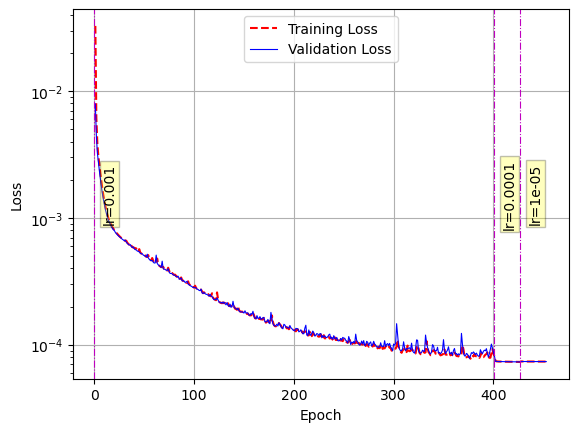

In [33]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 15


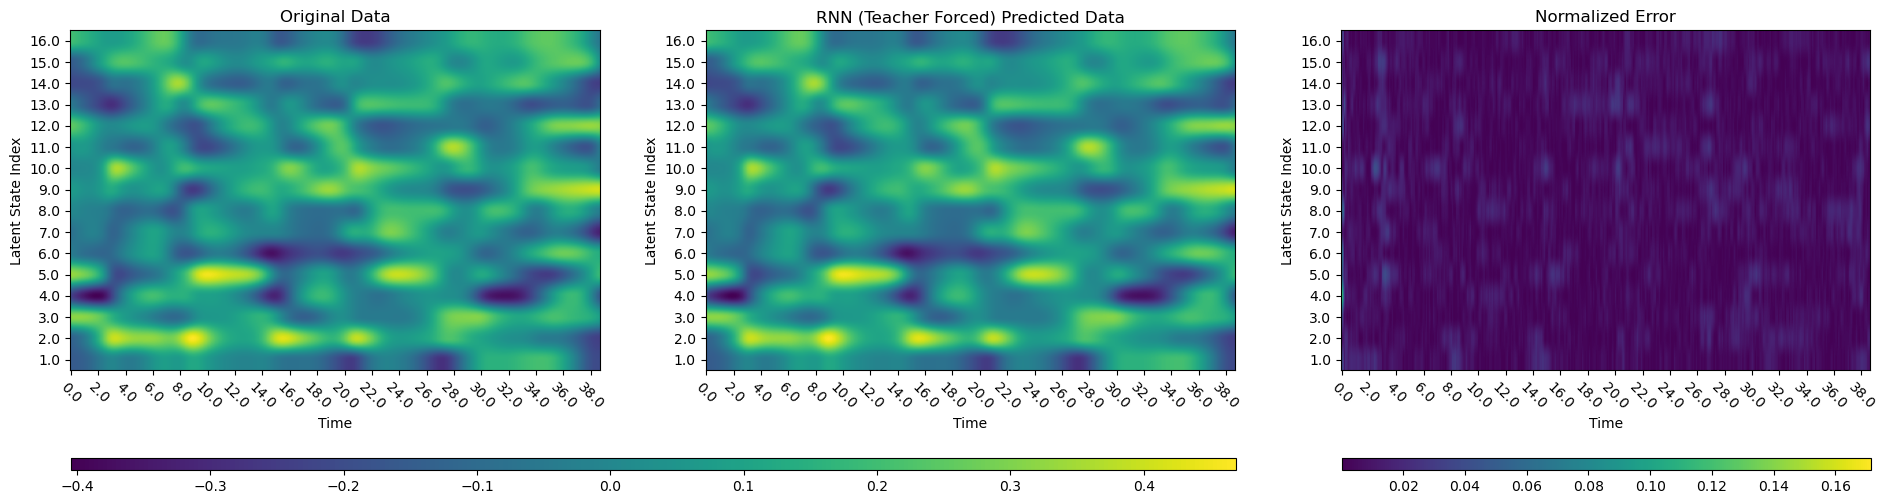

In [34]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [35]:
prediction.shape, data_out.shape

((1, 387, 16), (387, 16))

In [36]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 88


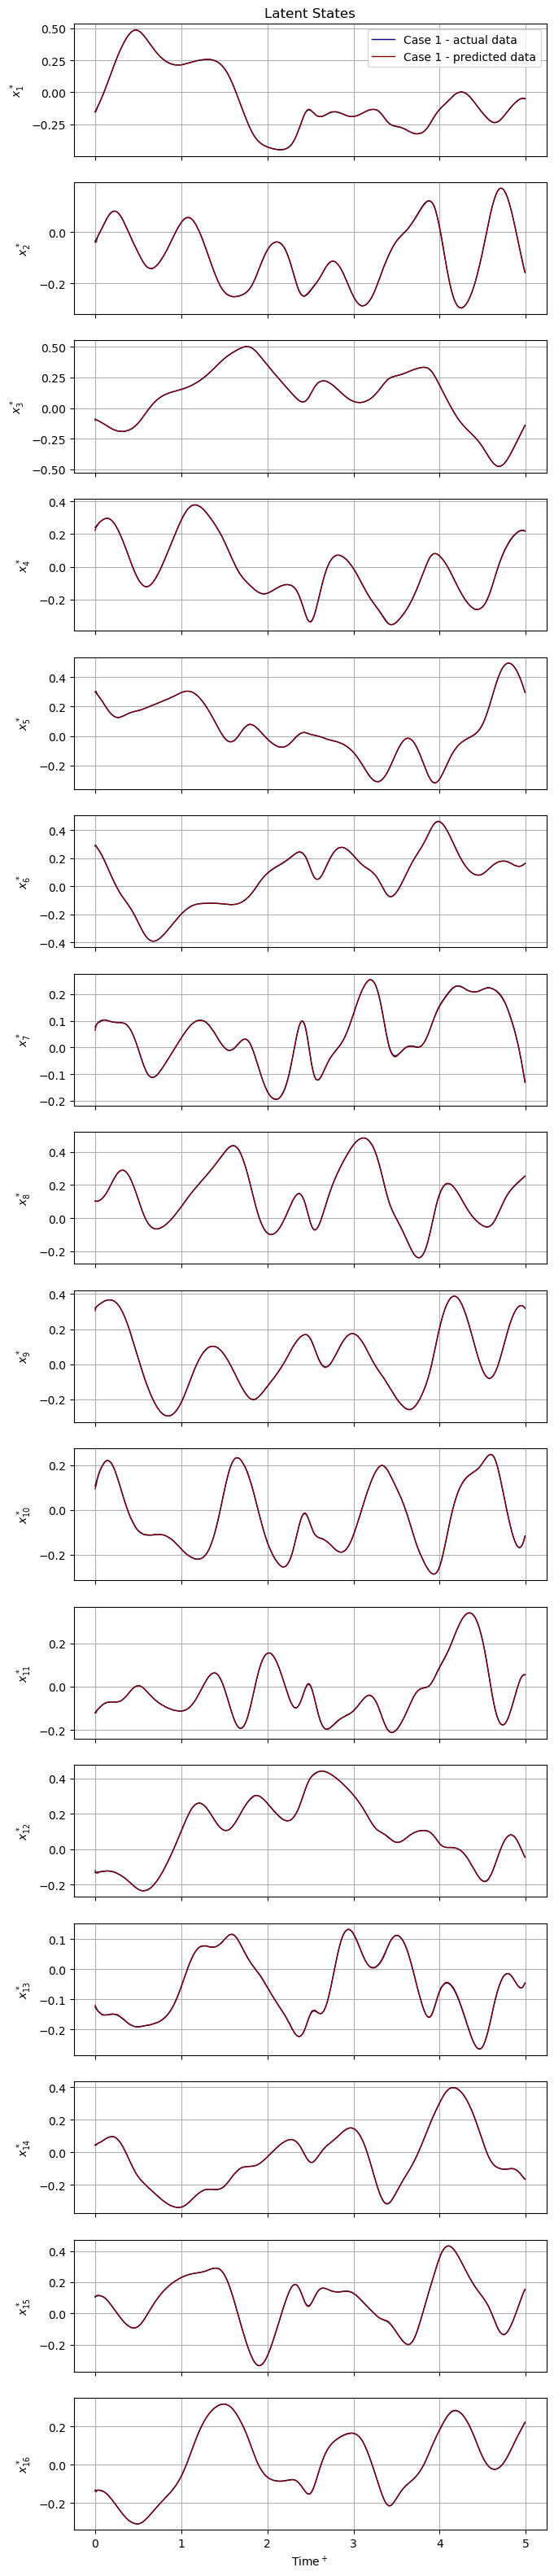

NameError: name 'time_stddev' is not defined

In [45]:
data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.linalg.norm(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0][0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)



plt.show()